In [1]:
!pip install -q transformers datasets
from datasets import load_dataset
from huggingface_hub import notebook_login
notebook_login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 12.9 MB/s eta 0:00:00


In [2]:
import numpy as np
from datasets import load_dataset
dataset = load_dataset("LucasThil/randomized_clean_miniwob_episodes_v2")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/13412 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/LucasThil___parquet/LucasThil--randomized_clean_miniwob_episodes_v2-49501296fc0102ba/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 1 - Get out Tokenizer Class
css_fields = ['top', 'left', 'width', 'height']
special_characters = ['.', ',', '#', ':', '-', '/', '(', ')', 'https://', '@', '&', '"', "'", '!', '?', ';', '+', '=',
                      '*', '$', '€', '*', '`']


def round_to_nearest_ten(number):
    return round(number / 10) * 10

import torch.nn as nn
import torch

# Embedding Function
class EmbeddingFunction(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(EmbeddingFunction, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, input_tokens):
        embedded = self.embedding(input_tokens)
        return embedded

    # Provide a tensor and de-embbeds it to retrieve the correct index
    def get_embedding_index(self, x):
        results = torch.where(torch.sum((self.embedding.weight == x), axis=1))
        if len(results[0]) == len(x):
            return None
        else:
            return results[0][0]

# Turn it into a class
class CCNeT5Tokenizer:
    def __init__(self, vocab_path):
        stoi = {}
        itos = {}
        self.padding_char = '<PAD>'
        self.special_characters = ['.', ',', '#', ':', '-', '/', '(', ')', 'https://', '@', '&', '"', "'", '!', '?',
                                   ';', '+', '=', '*', '$', '€', '*', '`']

        with open(vocab_path, 'r') as file:
            for index, line in enumerate(file):
                line = line.strip()
                stoi[line] = index
                itos[index] = line

        stoi[' '] = stoi['']
        itos[stoi[' ']] = ' '
        self.stoi = stoi
        self.stoi[self.padding_char] = len(stoi.keys())  # Add PADDING character
        # We do not need itos as we don't implement a de-tokinezing function.
        self.itos = itos
        self.itos[len(stoi.keys()) - 1] = self.padding_char  # Add PADDING character
        print(f'pad: {len(stoi.keys()) - 1}')
        print(f'Loaded CC_NeT5 Tokenizer with vocabulary size being {len(self.stoi)}.')

        # Instantiate the embedding function
        vocab_size = len(stoi)
        self.embedding_dim = 64
        self.embedding_fn = EmbeddingFunction(vocab_size, self.embedding_dim)

    # Provide a string and tokenize it: utterance or task name.
    def tokenize_string(self, string):
        tokenized_string = []
        for w in str(string).lower().split(' '):
            for sc in self.special_characters:
                if sc in w:
                    w = w.replace(sc, 'Ø' + sc + 'Ø')
            p1_words = [s for s in w.split('Ø') if s != '']
            # Check if the found words exist in our vocab, else subdivide
            for fw in p1_words:
                if fw not in self.stoi.keys():
                    for c in fw:
                        tokenized_string.append(self.stoi[c])
                else:
                    tokenized_string.append(self.stoi[fw])
        return tokenized_string

    def get_tokens_from_embeddings(self, embedded_tokens):
        indices = torch.Tensor(list(map(self.embedding_fn.get_embedding_index, embedded_tokens)))
        return indices

    # Turns an array into a string
    def detokenize_array(self, array):
        reconstruted_string = []
        #pad_index = self.itos[self.stoi[self.padding_char]]
        for v in array:
            v = int(v)
            s = self.itos[v]
            if s != self.padding_char:
                reconstruted_string.append(s)

        #reconstruted_string = ' '.join(reconstruted_string)
        cleaned_string = ''
        last_single = False
        for s in reconstruted_string:
            if len(s) > 1:
                if last_single:
                    cleaned_string += ' '
                    last_single = False
                cleaned_string += s + ' '
            else:
                # We do this to treat single length characters
                cleaned_string += s
                last_single = True
        return cleaned_string

    # Truncate and pad the incoming sentences based on a max_size argument
    def truncate_pad_entry(self, tokenized_array, max_size):
        if len(tokenized_array) < max_size:
            while len(tokenized_array) < max_size:
                tokenized_array.append(self.stoi[self.padding_char])
            return tokenized_array
        elif len(tokenized_array) > max_size:
            # Too long, so we automatically truncate
            return tokenized_array[:max_size]
        else:
            # Just avoid iterating under the hood
            return tokenized_array

    # Tokenize a DOM dictionary
    def tokenize_dom(self, dom):
        tokenized_dom = []

        # Add opening tag
        element_tag = dom['tag'].lower()
        if 'input' in dom.keys():
            # if tag is input, reformat it
            element_tag = dom['input'].lower() + '_' + dom['type'].lower()
            tokenized_dom.append(self.stoi['<' + element_tag])
        else:
            # add normal tag
            tokenized_dom.append(self.stoi['<' + dom['tag'].lower()])

        for field in dom:
            if field != 'tag' and field != 'children' and field != 'type' and field != 'text' and field not in css_fields:  # and field != 'value':

                tokenized_dom.append(self.stoi[field.lower()])

                # Ensure we don't have float values, we'll stick with integers
                if isinstance(dom[field], float):
                    tokenized_dom.append(self.stoi[str(int(round_to_nearest_ten(dom[field])))])
                else:
                    words = str(dom[field]).lower().split(' ')
                    for word in words:
                        for sc in special_characters:
                            if sc in word:
                                word = word.replace(sc, 'Ø' + sc + 'Ø')
                        p1_words = [s for s in word.split('Ø') if s != '']

                        # decides whether we keep the full word, or just the letters:
                        if field == 'value' or (False and (field == 'label' or field == 'button')):
                            for w in p1_words:
                                # Take individual characters of the value string
                                processed_words = [self.stoi[w[i:i + 1]] for i in range(0, len(w), 1)]
                                tokenized_dom += processed_words

                        elif field == 'ref':
                            for w in p1_words:
                                # Take individual characters of the value string
                                processed_words = [self.stoi[w[i:i + 3]] for i in range(0, len(w), 3)]
                                tokenized_dom += processed_words
                        else:
                            # Use the full word:
                            for w in p1_words:
                                tokenized_dom.append(self.stoi[str(w)])

            elif field == 'text':
                tokenized_dom.append(self.stoi['text'])
                for c in dom[field]:
                    tokenized_dom.append(self.stoi[c])
            elif field in css_fields:
                # Cast field
                tokenized_dom.append(self.stoi[field])
                css_value = int(round_to_nearest_ten(float(dom[field])))
                tokenized_dom.append(self.stoi[str(css_value)])

        if 'children' in dom.keys():
            tokenized_dom.append(self.stoi['children'])
            for child in dom['children']:
                tokenized_dom += self.tokenize_dom(child)
                # for v in found_vocab:
                #    tokenized_dom.append(self.stoi[v])

        # add closing tag
        tokenized_dom.append(self.stoi['</' + element_tag + '>'])

        return tokenized_dom

vocab_path="/content/drive/MyDrive/WebAI/Notebooks/CC_NeT5/vocab.txt"
tokenizer = CCNeT5Tokenizer(vocab_path=vocab_path)

pad: 1591
Loaded CC_NeT5 Tokenizer with vocabulary size being 1592.


In [5]:


# Load some of the images we have here and try to save them to the dataset
import os
from typing import List, Tuple
import numpy as np
from PIL import Image
import torch
import pandas as pd
import re
import json
from torch.utils.data import DataLoader
import random

class DatasetLoader:
    def __init__(self, screenshots_path, dataset, start_index, end_index, dom_tokenizer, batch_size):
        # Get the Subset of the dataset
        self.start_index = start_index
        self.end_index = end_index
        self.df = dataset['train'].to_pandas()[self.start_index:self.end_index]
        # When creating the class, parse JSON files into a state-based list structure
        self.df['processed_states'] = self.df['processed_states'].apply(lambda x: json.loads(re.sub(r'\b(True|False)\b', lambda m: m.group(0).lower(), x.replace("'", '"'))))
        print(f'Dataset subset has {len(self.df)} rows')

        self.screenshots_path = screenshots_path
        # If want to load them from the directory
        #self.indices, found_screenshots = self.get_file_indices()
        # Or load the previously saved indices
        self.indices = self.read_indices_from_file('/content/drive/MyDrive/WebAI/file_indices.txt')
        found_screenshots = len(self.indices)
        print(f'Found a total of {found_screenshots} state screenshots for {len(self.indices)} episodes.')

        self.add_images_to_episodes()

        self.dom_tokenizer = dom_tokenizer
        self.dom_seq_length = 492
        self.utterance_seq_length = 16
        self.task_name_seq_length = 4

        self.target_action_type_seq_length = 1
        self.target_ref_seq_length = 1
        self.target_keydown_seq_length = 8 #32

        # Size of the final layer output being composed of
        # 1 (action),
        # + 64 (ref) (
        # + 64x8 (keydown text times target_keydown_seq_length)
        self.model_output_size = 577

        self.batch_size = batch_size

    # Add the images to the different episodes of the dataset
    def add_images_to_episodes_old(self):
        found_images = []
        i = self.start_index
        image_counter = 0
        while i < self.end_index:
            if i % 100 == 0:
              print(f'Done: {i}')
            # Get K indices
            images = []
            try:
              state_indexes = self.indices[i]
              for state_index in state_indexes:
                  images.append(self.read_image(i, state_index))
                  image_counter += 1
              found_images.append(images)
            except:
              print(f'error {i}')
            i += 1
        # Add new column
        self.df['episode_images'] = found_images
        print(f'Found total of {image_counter} images in the loaded episodes.')

    # Load the images in batches
    def add_images_to_episodes(self):
      found_images = []
      image_counter = 0

      for i in range(self.start_index, self.end_index):
        if i%100 == 0:
          print(f'Done :{i}')
        try:
            state_indexes = self.indices[i]
            images = [self.read_image(i, state_index) for state_index in state_indexes]
            found_images.append(images)
            image_counter += len(images)
        except Exception as e:
            print(f'Error at index {i}: {str(e)}')

      self.df['episode_images'] = found_images
      print(f'Found a total of {image_counter} images in the loaded episodes.')


    def get_file_indices(self) -> List[Tuple[int, int]]:
        indices = []
        for filename in os.listdir(self.screenshots_path):
            if filename.endswith('.png'):
                # Extract the N and K values from the filename
                N, K = filename.replace('sc_', '').replace('st_', '').replace('.png', '').split('_')
                N = int(N)
                K = int(K)
                indices.append((N, K))

        # Turn the indices into a dictionary
        indices_dict = {}
        for (N, K) in indices:
            if N not in indices_dict:
                indices_dict[N] = [K]
            else:
                indices_dict[N].append(K)
                indices_dict[N] = sorted(indices_dict[N])

        return indices_dict, len(indices)

    def save_file_indices_to_file(self, dictionary, filename):
      with open(filename, 'w') as file:
          for key, value in dictionary.items():
              line = f"{key}: {value}\n"
              file.write(line)

    def read_indices_from_file(self, filename):
        dictionary = {}
        with open(filename, 'r') as file:
            for line in file:
                key, value = line.strip().split(': ')
                key = int(key)
                value = [int(num) for num in value.strip('[]').split(', ')]
                dictionary[key] = value
        return dictionary


    import torch

    # Reads images into tensor
    def read_image_old(self, N, K) -> torch.Tensor:
        filename = f'sc_{N}_st_{K}.png'
        filepath = os.path.join(self.screenshots_path, filename)
        image = Image.open(filepath).convert('RGB')
        tensor = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255.0
        return tensor

    # Pure NP instead of tensor
    def read_image(self, N, K) -> np.array:
        filename = f'sc_{N}_st_{K}.png'
        filepath = os.path.join(self.screenshots_path, filename)
        image = Image.open(filepath).convert('RGB')
        array = np.transpose(np.array(image) / 255.0, (2, 0, 1))
        return array


    def save_image_png(self, N, K):
        loaded_image = self.read_image(N, K).numpy()
        print(f'Image has shape {loaded_image.shape}')

        # scale the pixel values from [0,1] to [0, 255]
        array = np.clip(loaded_image * 255, 0, 255).astype('uint8')
        img = Image.fromarray(array.transpose(1, 2, 0), mode='RGB')
        img.save('screenshots/test_img.png')

    # Turn our dataset into a series of state tensors ready for training.
    # We though ensure to clearly separate our different instances:
    # - todo: T5-Data (for later, depends between SL or RL current approach)
    # - RBG
    # - todo: Tokenized DOM
    # - todo: Task Instruction
    # They are separated because they are not going to be fed in the same manner into the model.
    # Basically into one single row.
    # todo: skip rows that have negative rewards
    def process_dataset(self):
        rbg_data = []
        dom_data = []
        utterance_data = []
        task_name_data = []

        target_action = []
        target_refs = []
        target_keydown = []

        episode_previous_actions = []

        # Some metrics
        duplicated_images = 0
        cut_images = 0

        for (index, row) in self.df.iterrows():
            if float(row['reward']) <= 0: # Skips failed episodes
                continue
            if len(row['episode_images']) != len(row['processed_states']): # Skips episodes with no matching pictures amount and states
                len_processed_states = len(row['processed_states'])
                len_episode_images = len(row['episode_images'])
                print(f'Error: episode_images and processed_states don\' have the same length for index {index}: len_episode_images={len_episode_images}, len_processed_states={len_processed_states}')
                # We just discard it, fuck it if it's just an individual row and only one image missing out of n states.
                # Data processing showed that only few states were missing from the zip and got fixed except a couple of them

                # Ok actually fix it by cloning the last rgb
                if len_episode_images < len_processed_states:
                  last_img = row['episode_images']
                  while len(row['episode_images']) < len_processed_states:
                    row['episode_images'].append(last_img)
                    duplicated_images += 1
                else:
                  # Too few processed states for pictures, cut last pic.
                  # We keep the processed states over the generated screenshots
                  row['episode_images'] = row['episode_images'][:len_processed_states]
                  cut_images += len_episode_images - len_processed_states
                continue
            for rbg in row['episode_images']:
                rbg = np.array(rbg, dtype='float64')
                #print(f'rbg shape: {rbg.shape}')
                rbg_data.append(rbg)


            # Process DOM Data
            for (index_state, state) in enumerate(row['processed_states']):

                # Output Tokens
                if state['action_type'] == 'click': # Append boolean for action click or keydown
                    t_action = np.array([0])
                    target_action.append(t_action)
                else:
                    t_action = np.array([1])
                    target_action.append(t_action)

                # Tokenize ref and appends to target
                t_ref = np.array(self.dom_tokenizer.truncate_pad_entry(self.dom_tokenizer.tokenize_string(str(state['refs'])), self.target_ref_seq_length))
                target_refs.append(t_ref)
                # Tokenize target text and appends to target
                t_keydown = np.array(self.dom_tokenizer.truncate_pad_entry(self.dom_tokenizer.tokenize_string(state['keydown_text']), self.target_keydown_seq_length))
                target_keydown.append(t_keydown)

                # Input Tokens
                # Tokenize dom
                tokenized_dom = self.dom_tokenizer.tokenize_dom(state['dom'])
                tokenized_dom = self.dom_tokenizer.truncate_pad_entry(tokenized_dom, self.dom_seq_length)
                dom_data.append(tokenized_dom)

                # Tokenize utterance
                tokenized_utterance = self.dom_tokenizer.truncate_pad_entry(self.dom_tokenizer.tokenize_string(row['utterance']), self.utterance_seq_length)
                utterance_data.append(tokenized_utterance)

                # Tokenize task name
                tokenized_task_name = self.dom_tokenizer.truncate_pad_entry(self.dom_tokenizer.tokenize_string(row['task_name']), self.task_name_seq_length)
                task_name_data.append(tokenized_task_name)

                # Deal with the previous action
                if index_state < len(row['processed_states'])-1:
                    # Default one so empty for the first action
                    if index_state == 0:
                        episode_previous_actions.append([])
                        #episode_previous_actions.append(self.dom_tokenizer.truncate_pad_entry(self.dom_tokenizer.tokenize_string(''), self.model_output_size))

                    # Add previous actions one by one
                    episode_previous_actions.append([t_action, t_ref, t_keydown])
                elif index_state >= len(row['processed_states'])-1 and index_state == 0:
                    episode_previous_actions.append([])
                # Else no action to add




        rbg_data = np.stack(rbg_data)
        dom_data = np.array(dom_data)
        utterance_data = np.array(utterance_data)
        task_name_data = np.array(task_name_data)
        target_action = np.array(target_action)
        target_refs = np.array(target_refs)
        target_keydown = np.array(target_keydown)

        print(f'duplicated_images: {duplicated_images}, cut_images: {cut_images}')

        return rbg_data, dom_data, utterance_data, task_name_data, target_action, target_refs, target_keydown, episode_previous_actions


    # Batchify the dataset
    def get_dataloder(self, dataset):
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return train_loader

    # Creates random indexes to split and shuffle the test and training datasets
    def create_train_test_dataset(self, length):
        # Calculate the number of random indexes (10% of length)
        num_random_indexes = int(length * 0.1)

        # Generate random indexes without replacement
        random_indexes = random.sample(range(length), num_random_indexes)

        # Create train and test datasets
        train_dataset = []
        test_dataset = []

        for i in range(length):
            if i in random_indexes:
                test_dataset.append(i)
            else:
                train_dataset.append(i)

        # Shuffle the train and test datasets
        random.shuffle(train_dataset)
        random.shuffle(test_dataset)

        return train_dataset, test_dataset

    # Devise datasets
    def split_datasets(self, rbg_data, dom_data, utterance_data, task_name_data, target_action, target_refs, target_keydown, episode_previous_actions):
        train_indexes, test_indexes = self.create_train_test_dataset(length=len(rbg_data))

        train_rgb = rbg_data[train_indexes]
        train_dom = dom_data[train_indexes]
        train_utterance = utterance_data[train_indexes]
        train_task_name = task_name_data[train_indexes]
        train_target_action = target_action[train_indexes]
        train_target_ref = target_refs[train_indexes]
        train_target_keydown = target_keydown[train_indexes]
        train_episode_previous_action = []
        for index in train_indexes:
            train_episode_previous_action.append(episode_previous_actions[index])

        # Create a boolean mask of the indexes
        test_rgb = rbg_data[test_indexes]
        test_dom = dom_data[test_indexes]
        test_utterance = utterance_data[test_indexes]
        test_task_name = task_name_data[test_indexes]
        test_target_action = target_action[test_indexes]
        test_target_ref = target_refs[test_indexes]
        test_target_keydown = target_keydown[test_indexes]
        test_episode_previous_action = []
        for index in test_indexes:
            test_episode_previous_action.append(episode_previous_actions[index])

        return train_rgb, train_dom, train_utterance, train_task_name, train_target_action, train_target_ref, \
               train_target_keydown, train_episode_previous_action, test_rgb, test_dom, test_utterance, \
               test_task_name, test_target_action, test_target_ref, test_target_keydown, test_episode_previous_action



In [ ]:
screenshots_path = '/content/drive/MyDrive/WebAI/screenshot_indexes'
batch_size = 12
# NOTE!!!: Check if need to rerun the indices on all pictures instead of range
dataset_loader = DatasetLoader(screenshots_path=screenshots_path, dataset=dataset, start_index=0, end_index=8000, dom_tokenizer=tokenizer, batch_size=batch_size)

Dataset subset has 8000 rows
Found a total of 7266 state screenshots for 7266 episodes.
Done :0
Error at index 0: [Errno 5] Input/output error: '/content/drive/MyDrive/WebAI/screenshot_indexes/sc_0_st_0.png'


In [ ]:
rgb_data, dom_data, utterance_data, task_data, target_action, target_refs, target_keydown, episode_previous_actions = dataset_loader.process_dataset()

Error: episode_images and processed_states don' have the same length for index 6: len_episode_images=4, len_processed_states=3
Error: episode_images and processed_states don' have the same length for index 374: len_episode_images=5, len_processed_states=7
Error: episode_images and processed_states don' have the same length for index 396: len_episode_images=2, len_processed_states=3
Error: episode_images and processed_states don' have the same length for index 504: len_episode_images=3, len_processed_states=4
Error: episode_images and processed_states don' have the same length for index 586: len_episode_images=2, len_processed_states=3
Error: episode_images and processed_states don' have the same length for index 588: len_episode_images=2, len_processed_states=3
Error: episode_images and processed_states don' have the same length for index 594: len_episode_images=2, len_processed_states=3
Error: episode_images and processed_states don' have the same length for index 596: len_episode_ima

In [ ]:
len(rgb_data), len(dom_data), len(utterance_data), len(task_data), len(target_action), len(target_refs), len(target_keydown), len(episode_previous_actions)

(4358, 4358, 4358, 4358, 4358, 4358, 4358, 4358)

In [ ]:

# Create Train/Test Splits
train_rgb, train_dom, train_utterance, train_task_name, train_target_action, train_target_ref, \
               train_target_keydown, train_episode_previous_action, test_rgb, test_dom, test_utterance, test_task_name, test_target_action, \
               test_target_ref, test_target_keydown, test_episode_previous_action = dataset_loader.split_datasets(rgb_data, dom_data, utterance_data, task_data, target_action, target_refs, target_keydown, episode_previous_actions)

train_rgb.shape, train_dom.shape, train_utterance.shape, train_task_name.shape, train_target_action.shape, train_target_ref.shape, \
               train_target_keydown.shape, \
test_rgb.shape, test_dom.shape, test_utterance.shape, test_task_name.shape, test_target_action.shape, test_target_ref.shape, \
    test_target_keydown.shape


((3923, 3, 210, 160),
 (3923, 492),
 (3923, 16),
 (3923, 4),
 (3923, 1),
 (3923, 1),
 (3923, 8),
 (435, 3, 210, 160),
 (435, 492),
 (435, 16),
 (435, 4),
 (435, 1),
 (435, 1),
 (435, 8))

In [ ]:

import numpy as np
import torch

def format_language_rgb_input(rgb_data, dom_data, utterance_data, task_data):
    # Put language task together
    language_input = np.concatenate((dom_data, utterance_data, task_data), axis=1)
    #language_input = dom_data
    print(language_input.shape)

    rgb_data = torch.from_numpy(rgb_data).type(torch.float32)
    language_input = torch.from_numpy(language_input).type(torch.long)
    language_input = tokenizer.embedding_fn(language_input) # Create embeddings for language
    print(f'rgb_data: {rgb_data.shape}, language_input: {language_input.shape}')
    return rgb_data, language_input

train_rgb_data, train_language_input = format_language_rgb_input(rgb_data=train_rgb, dom_data=train_dom, utterance_data=train_utterance, task_data=train_task_name)
test_rgb_data, test_language_input = format_language_rgb_input(rgb_data=test_rgb, dom_data=test_dom, utterance_data=test_utterance, task_data=test_task_name)


(3923, 512)
rgb_data: torch.Size([3923, 3, 210, 160]), language_input: torch.Size([3923, 512, 64])
(435, 512)
rgb_data: torch.Size([435, 3, 210, 160]), language_input: torch.Size([435, 512, 64])


In [ ]:

# Test formatting of previous action sequence data.
# TODO: need to update the dataloader with them
def format_previous_actions(episode_previous_actions, tokenizer, dataset_loader):
    formatted_previous_actions = []

    # Process one by one the different entries to have them correctly matching the dataset
    for entry in episode_previous_actions:
        # No previous action, have default empty sequence
        if len(entry) == 0:
            empty_action = np.array(tokenizer.truncate_pad_entry(tokenizer.tokenize_string(''), dataset_loader.model_output_size))
            formatted_previous_actions.append(empty_action)
        else:
            action_type = torch.from_numpy(entry[0]).type(torch.long)
            ref = torch.from_numpy(entry[1]).type(torch.long)
            ref = torch.flatten(tokenizer.embedding_fn(ref))
            keydown = torch.flatten(tokenizer.embedding_fn(torch.from_numpy(entry[2]).type(torch.long)))
            together = np.concatenate((action_type.detach().numpy(), ref.detach().numpy(), keydown.detach().numpy()))
            formatted_previous_actions.append(together)

    formatted_previous_actions = np.array(formatted_previous_actions)
    return formatted_previous_actions

# These are the formatted actions to use when concatenating after the multimodal layers.
train_formatted_previous_actions = format_previous_actions(episode_previous_actions=train_episode_previous_action, tokenizer=tokenizer, dataset_loader=dataset_loader)
print(f'Got TRAIN {len(train_formatted_previous_actions)} formatted_previous_actions, type: {train_formatted_previous_actions.dtype}')
# into tensor
train_formatted_previous_actions = torch.from_numpy(train_formatted_previous_actions)
print(f'formatted_previous_actions: {train_formatted_previous_actions.shape}, {train_formatted_previous_actions.dtype}')

# These are the formatted actions to use when concatenating after the multimodal layers.
test_formatted_previous_actions = format_previous_actions(episode_previous_actions=test_episode_previous_action, tokenizer=tokenizer, dataset_loader=dataset_loader)
print(f'Got TEST {len(test_formatted_previous_actions)} formatted_previous_actions, type: {test_formatted_previous_actions.dtype}')
# into tensor
test_formatted_previous_actions = torch.from_numpy(test_formatted_previous_actions)
print(f'formatted_previous_actions: {test_formatted_previous_actions.shape}, {test_formatted_previous_actions.dtype}')


Got TRAIN 3923 formatted_previous_actions, type: float64
formatted_previous_actions: torch.Size([3923, 577]), torch.float64
Got TEST 435 formatted_previous_actions, type: float64
formatted_previous_actions: torch.Size([435, 577]), torch.float64


In [ ]:

# Produces target labels.
# TODO: also use it to format the T5 output text to feed CC-NeT5
def produce_labels(target_action, target_refs, target_keydown, tokenizer):
    i = 0
    labels = []

    while i<len(target_action):
        # Tokenize refs and keydowns
        embedded_action = torch.from_numpy(target_action[i]).detach().numpy()
        embedded_ref = torch.flatten(tokenizer.embedding_fn(torch.from_numpy(target_refs[i]))).detach().numpy()
        embedded_keydown = torch.flatten(tokenizer.embedding_fn(torch.from_numpy(target_keydown[i]))).detach().numpy()

        label = np.concatenate((embedded_action, embedded_ref, embedded_keydown), axis=0)
        labels.append(label)
        i += 1

    labels = np.array(labels)
    labels = torch.from_numpy(labels).type(torch.float32)
    return labels

train_labels = produce_labels(train_target_action, train_target_ref, train_target_keydown, tokenizer)
test_labels = produce_labels(test_target_action, test_target_ref, test_target_keydown, tokenizer)
train_labels.shape, test_labels.shape


(torch.Size([3923, 577]), torch.Size([435, 577]))

In [ ]:
# Batchify data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#batched_rgb = dataset_loader.get_dataloder(dataset=rgb_data.to(torch.device(device)))
#batched_language = dataset_loader.get_dataloder(dataset=language_input.to(torch.device(device)))
#batched_previous_actions = dataset_loader.get_dataloder(dataset=formatted_previous_actions.to(torch.device(device)))
#batched_labels = dataset_loader.get_dataloder(dataset=labels.to(torch.device(device)))

# Batchify data
train_batched_rgb = dataset_loader.get_dataloder(dataset=train_rgb_data.to(torch.device(device)))
train_batched_language = dataset_loader.get_dataloder(dataset=train_language_input.to(torch.device(device)))
train_batched_previous_actions = dataset_loader.get_dataloder(dataset=train_formatted_previous_actions.to(torch.device(device)))
train_batched_labels = dataset_loader.get_dataloder(dataset=train_labels.to(torch.device(device)))

test_batched_rgb = dataset_loader.get_dataloder(dataset=test_rgb_data.to(torch.device(device)))
test_batched_language = dataset_loader.get_dataloder(dataset=test_language_input.to(torch.device(device)))
test_batched_previous_actions = dataset_loader.get_dataloder(dataset=test_formatted_previous_actions.to(torch.device(device)))
test_batched_labels = dataset_loader.get_dataloder(dataset=test_labels.to(torch.device(device)))


In [ ]:
# Some model classes

'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=2):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3),
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=14):
        super(ResNet, self).__init__()
        self.in_planes = 3

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        #self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(x)
        dl1 = out.shape
        out = self.layer2(out)
        dl2 = out.shape
        out = self.layer3(out)
        dl3 = out.shape
        out = self.layer4(out)
        dl4 = out.shape
        #out = F.avg_pool2d(out, 4)
        #out = out.view(out.size(0), -1)

        # Flatten (batch size, channels, features)
        out = out.view(batch_size, 512, 140)
        out_1_s = out.shape
        # Might have to change the last layer to obtain our 14x11 feature vector?
        #out = self.linear(out)
        #print(f'out_1_s: {out_1_s}, out: {out.shape}')
        #print(f'dl1: {dl1}, dl2: {dl2}, dl3: {dl3}, dl4: {dl4}, out: {out_1_s}')
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# ----------------------------------
# Cross Attention Model for Language
class CrossAttentionModelLanguage(nn.Module):
    # Changed hidden_dim from 140 to 1
    def __init__(self, input_dim=64, hidden_dim=1, num_heads=4):
        super(CrossAttentionModelLanguage, self).__init__()

        self.attention = nn.MultiheadAttention(input_dim, num_heads)
        self.linear = nn.Linear(input_dim, hidden_dim)

    def forward(self, input):
        # Reshape the input to (sequence_length, batch_size, input_dim)
        input = input.permute(1, 0, 2)

        # Apply cross-attention
        output, _ = self.attention(input, input, input)

        # Reshape the output to (batch_size, sequence_length, input_dim)
        output = output.permute(1, 0, 2)

        # Apply linear transformation
        output = self.linear(output)

        return output


#--------------------------------
# Multimodal Transformer Network 
from torch.nn import Transformer

class TransformerNetwork(nn.Module):
    def __init__(self):
        super(TransformerNetwork, self).__init__()

        self.embedding_dim = 512
        self.num_layers = 8
        self.num_heads = 8

        self.embedding = nn.Linear(142, self.embedding_dim)
        self.transformer = Transformer(
            d_model=self.embedding_dim,
            nhead=self.num_heads,
            num_encoder_layers=self.num_layers,
            num_decoder_layers=self.num_layers
        )
        #self.output_layer = nn.Linear(self.embedding_dim, 1)

    def forward(self, input_tensor):
        batch_size = input_tensor.size(0)

        embedded = self.embedding(input_tensor)
        embedded = embedded.permute(1, 0, 2)

        output = self.transformer(embedded, embedded)
        output = output.permute(1, 0, 2)
        #output = self.output_layer(output)

        return output.squeeze(2)

#-------------------
# LSTM Netowkr Part
class TwoLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TwoLSTM, self).__init__()
        self.hidden_size = hidden_size

        # Note: we use a Linear layer for dimension adjustment.
        # Indeed, the previous multi-modal transformer outputs a 1024 + prev_action length tensor,
        # and here the LSTM layers have a 512 dim where we also need to bypass residual connections.
        # We use the linear layer below to have a matching size with the input/output of these LSTMs
        # in order to concatenate them.
        self.linear = nn.Linear(input_size, hidden_size)

        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=2, batch_first=True)

        # This linear layer is for the final mapping
        #self.fc = nn.Linear(hidden_size, output_size) #fully connected last layer

    def forward(self, input):
        # Perform dimension adjustment using the linear layer
        adjusted_input = self.linear(input)
        #print(f'adjusted_input: {adjusted_input.shape}')

        # Perform the forward pass through each LSTM layer
        output, _hidden_state = self.lstm(adjusted_input)

        # Perform residual connections between LSTM layers
        residual_output = adjusted_input + output

        # Extract the hidden state of the last LSTM layer after residual connections
        last_hidden_state = residual_output[:, -1, :]

        #out = self.fc(last_hidden_state)
        return last_hidden_state

In [ ]:

import torch.nn as nn
import torch
import torch.nn.functional as F

class CCNeT5(nn.Module):
    def __init__(self):
        super().__init__()
        #self.rgb_model = nn.Sequential(*resnet_blocks)
        self.rgb_model = ResNet18()
        self.language_model = CrossAttentionModelLanguage()

        # Multi Modal Part Combining RGB + Language
        #self.multimodal_transformer = MultiModalTransformer()
        self.multimodal_transformer = TransformerNetwork()

        # Here we should concatenate with the previous Action
        # when doing the forward pass

        # Two-Layer LSTM
        self.lstm = TwoLSTM(1089, 513)

        # Last output Layer to create a proper action space from the original language embeddings
        self.fc = nn.Linear(513, 577) #fully connected last layer

        # T5 Decreased
        # Linear layer to reduce the size of the T5 output frm 577 to 512
        self.fc_t5 = nn.Linear(577, 512)


    # todo: pass previous action
    def forward(self, rgb_input, language_input, previous_action, t5_output):
        # Process RGB input
        rgb_output = self.rgb_model(rgb_input)

        # Process language input
        language_output = self.language_model(language_input)

        #print(f'shape rbg_output: {rgb_output.shape}, shape language_output: {language_output.shape}')
        flattened_tensor1 = rgb_output.view(batch_size, 512*140)
        flattened_tensor2 = language_output.view(batch_size, -1)

        # Concatenate tensor1 and flattened_tensor2 along the last dimension
        fused_output = torch.cat((flattened_tensor1, flattened_tensor2), dim=1).view(batch_size, 512, 141)

        # Add T5 output to image and language tensor
        t5_output = self.fc_t5(t5_output).unsqueeze(dim=2) # Change shape from (batch, 577) to (batch, 512, 1)
        # Concatenate with fused output
        fused_output = torch.cat((fused_output, t5_output), dim=2)

        # Further processing or fusion of modalities
        #print(f'fused_output: {fused_output.shape} - {fused_output.dtype}')
        # Additional processing steps...

        # Permute
        #fused_output = fused_output.permute(0, 2, 1)

        # Feed into Multimodal Transformer
        multimodal_output = self.multimodal_transformer(fused_output)
        #print(f'multimodal_output: {multimodal_output.shape} - type: {multimodal_output.dtype}')

        # TODO: concatenate with previous action
        #print(f'previous_action: {previous_action.shape}')
        #tensor2_reshaped = F.pad(previous_action, (0, 447), mode='constant')
        #tensor2_expanded = torch.unsqueeze(tensor2_reshaped, dim=2)  # Shape: [8, 1024, 577]
        #combined_tensor = torch.cat((multimodal_output, tensor2_expanded), dim=2).type(torch.float32) # Shape: [8, 1024, 1089]

        tensor2 = previous_action.unsqueeze(1)
        # Expand tensor2 dimensions to match tensor1
        tensor2 = tensor2.expand(-1, 512, -1)
        # Combine the tensors
        combined_tensor = torch.cat((multimodal_output, tensor2), dim=2).type(torch.float32)
        #print(f'concatenation previous action: {combined_tensor.shape}')

        # Feed into LSTM
        # + Permute to fit the right format
        #lstm_output = self.lstm(combined_tensor.permute(0, 2, 1))
        lstm_output = self.lstm(combined_tensor)
        #print(f'lstm_output: {lstm_output.shape}')

        # Last layer to target action space
        action_output = self.fc(lstm_output)

        return action_output


In [ ]:
multimodal = CCNeT5()
multimodal

CCNeT5(
  (rgb_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): BasicBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchN

In [ ]:

import torch.optim as optim
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multimodal.to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(multimodal.parameters(), lr=1e-4)
losses = []

def train_model(model, batched_rgb, batched_language, batched_previous_actions, batched_labels):
    i = 0
    total_iters = len(train_batched_rgb)
    print(f'total_iters/', end='')
    cumulated_loss = 0
    for rgb_data, language_data, previous_action, targets in zip(batched_rgb, batched_language, batched_previous_actions, batched_labels):
        optimizer.zero_grad()

        print('#', end='')

        # T5 Input
        # Here we put the input from the T5 model, for now the targets in the first offline patch
        t5_output = targets.clone()

        #print(rgb_data.dtype, language_data.dtype, previous_action.dtype, targets.dtype)

        #print(f'iteration {i}')
        if rgb_data.shape[0] != batch_size or previous_action.shape[0] != batch_size:
            # If we have a smaller batch, discard it as we don't handle it currently
            #print(f'current batch size: {rgb_data.shape[0]}')
            continue
        #print(rgb_data.shape)
        #print(language_data.shape)
        rgb_data = rgb_data.to(device)
        language_data = language_data.to(device)
        action_output = model.forward(rgb_data, language_data, previous_action, t5_output)
        #print(f'action_output: {action_output.shape} - {action_output.dtype}')
        #print(f'targets: {targets.shape} - {targets.dtype}')

        loss = loss_function(action_output, targets)
        loss.backward(retain_graph=True)
        optimizer.step()
        cumulated_loss += loss.item()
        #print(f'{i}/{len(total_iters)}')
        i += 1

# Test Model
def test_model(model, batched_rgb, batched_language, batched_previous_actions, batched_labels):
    i = 0
    total_iters = len(batched_rgb)
    print(f'Running Evaluation Test: {total_iters}/', end='')
    cumulated_loss = 0


    for rgb_data, language_data, previous_action, targets in zip(batched_rgb, batched_language, batched_previous_actions, batched_labels):
        optimizer.zero_grad()

        print('#', end='')

        # T5 Input
        # Here we put the input from the T5 model, for now the targets in the first offline patch
        t5_output = targets.clone()

        #print(f'iteration {i}')
        if rgb_data.shape[0] != batch_size:
            # If we have a smaller batch, discard it as we don't handle it currently
            #print(f'current batch size: {rgb_data.shape[0]}')
            continue
        #print(rgb_data.shape)
        #print(language_data.shape)
        rgb_data = rgb_data.to(device)
        language_data = language_data.to(device)
        action_output = model.forward(rgb_data, language_data, previous_action, t5_output)
        #print(f'action_output: {action_output.shape} - {action_output.dtype}')
        #print(f'targets: {targets.shape} - {targets.dtype}')
        #print(f'Eval {i} / {total_iters}')

        cumulated_loss += loss_function(action_output, targets).item()
        i += 1
    return cumulated_loss / i


In [ ]:
epochs = 10
i = 0
losses = []
while i < epochs:
    train_model(multimodal, train_batched_rgb, train_batched_language, train_batched_previous_actions, train_batched_labels)
    epoch_loss = test_model(multimodal, test_batched_rgb, test_batched_language, test_batched_previous_actions, test_batched_labels)

    print(f'Epoch {i} has loss {epoch_loss}')

    # Saves the entire model
    torch.save(multimodal, f'/content/drive/MyDrive/WebAI/Model Weights/CCNeT5_OffLine1/CCNeT5_{i}')
    losses.append(epoch_loss)
    i += 1

total_iters/##########################################################################################################################################################################################################################################################################################

In [ ]:
#import gc
#del multimodal
#gc.collect()
#torch.cuda.empty_cache()

KeyboardInterrupt: ignored

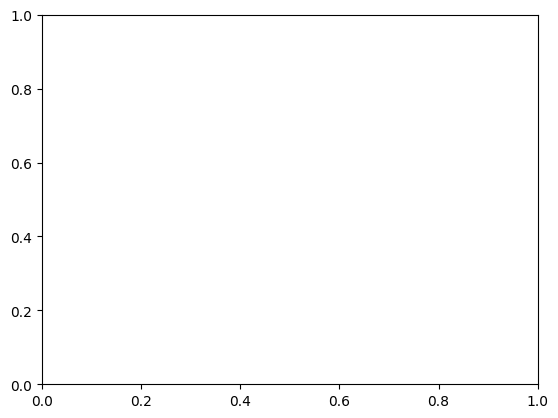

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
# Saves the entire model
torch.save(multimodal, '/content/drive/MyDrive/WebAI/Model Weights/CCNeT5_Smaller_1_500.pth')

In [ ]:
device